# Random Forest Regression
## Module import

In [11]:
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

## Base model evaluation

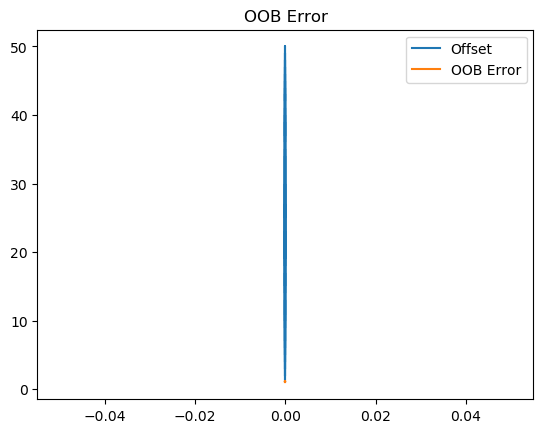

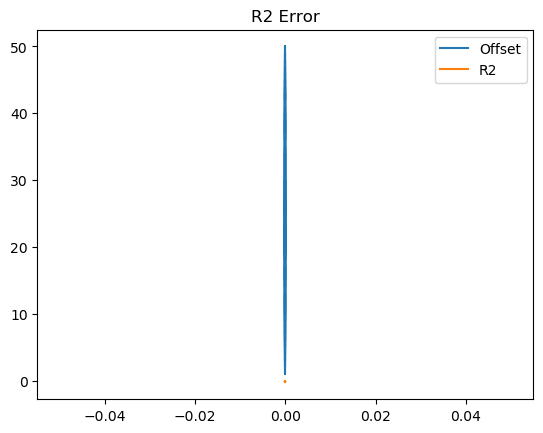

In [4]:
# Set the directory containing the CSV files
input_directory = '../../1-preprocessing/data/6-time-lags/USD'

# Create a DataFrame to store the results
oob_results = pd.DataFrame(columns=['Offset', 'OOB Error'])
r2_results = pd.DataFrame(columns=['Offset', 'R2'])

# Loop through the files in the directory
for filename in os.listdir(input_directory):
    if filename == '10.csv':
        if filename.endswith('.csv'):
            # Extract the offset from the filename
            offset = int(filename.split('.')[0])
    
            # Load the data from the CSV file
            data = pd.read_csv(os.path.join(input_directory, filename))
    
            # Split the data into features and target
            X = data.iloc[:, 1:-1]
            y = data.iloc[:, -1]
    
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                test_size=0.1,
                random_state=42
            )
            
            # Fit the RandomForestRegressor model
            model = RandomForestRegressor(
                n_estimators=100,
                oob_score=True,
                random_state=0
            )
            model.fit(X_train, y_train)
    
            # Calculate the OOB error
            oob_error = 1 - model.oob_score_

            # Calculate the R-squared score
            y_pred = model.predict(X_test)
            r2 = r2_score(y_test, y_pred)
    
            # Add the results to the DataFrame
            oob_results = pd.concat([oob_results, pd.DataFrame({'Offset': [offset], 'OOB Error': [oob_error]})])
            r2_results = pd.concat([r2_results, pd.DataFrame({'Offset': [offset], 'R2': [r2]})])


## Plot results

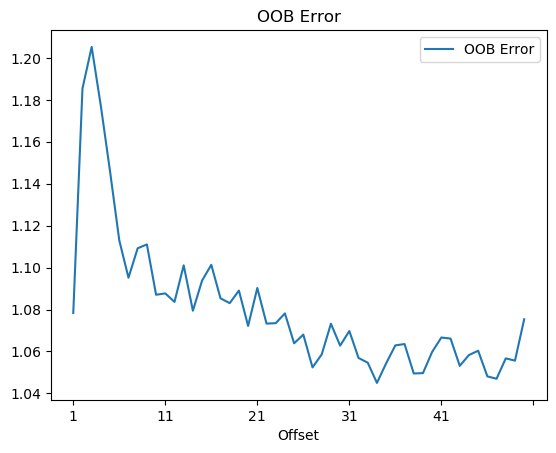

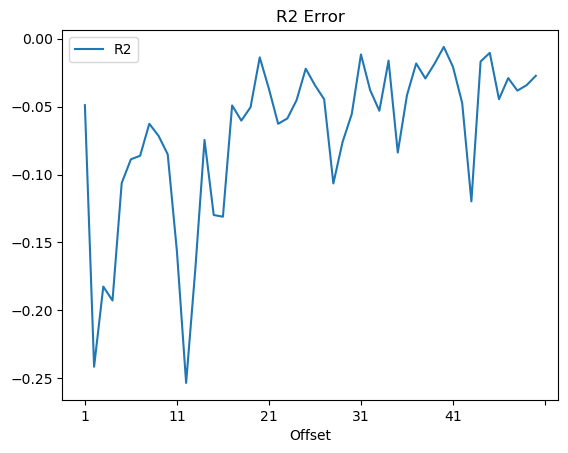

In [11]:
sorted_oob = oob_results.sort_values(by='Offset')
sorted_oob.plot(title='OOB Error', x='Offset', y='OOB Error')

sorted_r2 = r2_results.sort_values(by='Offset')
sorted_r2.plot(title='R2 Score', x='Offset', y='R2')

## Save results to a CSV file

In [12]:
sorted_oob.to_csv('oob_error_results.csv', index=False)
sorted_r2.to_csv('r2_results.csv', index=False)

## Hyperparameter Grid Search

Directional Symmetry (hit rate): 0.92
Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best R^2 score: -0.001


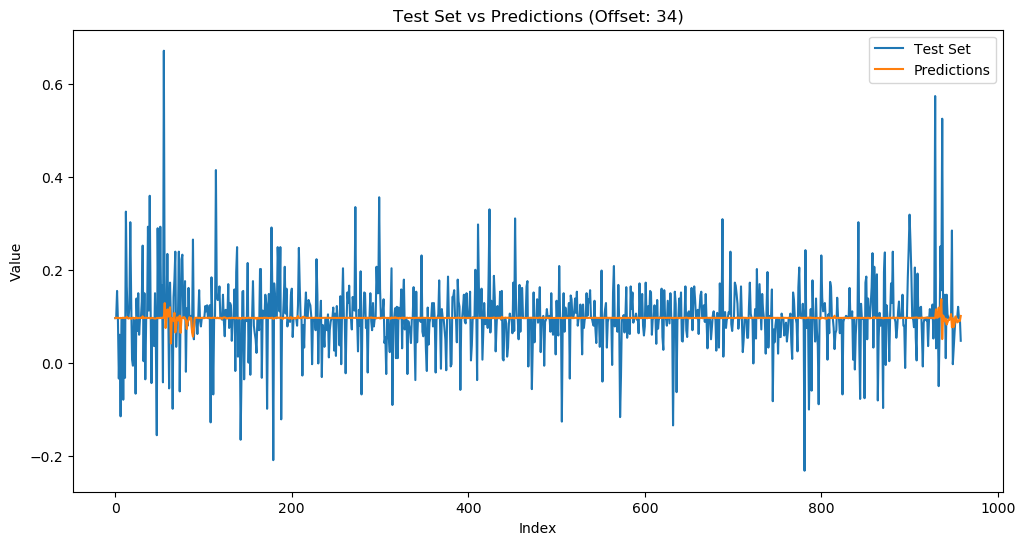

In [39]:
param_grid = {
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth': [5],
    'min_samples_split': [5],
    'min_samples_leaf': [2]
}

# Set the directory containing the CSV files
input_directory = '../../1-preprocessing/data/6-time-lags/USD'

# Create a DataFrame to store the results
oob_results = pd.DataFrame(columns=['Offset', 'OOB Error'])
r2_results = pd.DataFrame(columns=['Offset', 'R2'])

# Loop through the files in the directory
for filename in os.listdir(input_directory):
    if filename == '34.csv':
        if filename.endswith('.csv'):
            # Extract the offset from the filename
            offset = int(filename.split('.')[0])
    
            # Load the data from the CSV file
            data = pd.read_csv(os.path.join(input_directory, filename))
    
            # Split the data into features and target
            X = data.iloc[:, 1:-1]
            y = data.iloc[:, -1]
            date = data.iloc[:, 0]
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(
                X,
                y,
                shuffle=False,
                test_size=0.1,
                random_state=42
            )

            # Initialize model
            model = RandomForestRegressor(
                oob_score=True,
                random_state=0
            )

            grid_search = GridSearchCV(
                estimator=model,
                param_grid=param_grid,
                cv=5,             # 5-fold cross-validation
                scoring='r2',     # evaluation metric
                n_jobs=-1         # use all available CPU cores
            )
            
            # Fit the RandomForestRegressor model
            grid_search.fit(X_train, y_train)

            best_model = grid_search.best_estimator_

            y_pred = best_model.predict(X_test)
            y_true = y_test

            # print("y_true")
            # print(y_true.values)
            # print("y_pred")
            # print(y_pred)
            
            # Calculate the Directional Symmetry (hit rate)
            hit_rate = (np.sign(y_pred) == np.sign(y_test)).mean()

            print(f"Directional Symmetry (hit rate): {hit_rate:.2f}")
            
            print(f"Best parameters: {grid_search.best_params_}")
            print(f"Best R^2 score: {grid_search.best_score_:.3f}")

            # Plot the test set and the predictions
            plt.figure(figsize=(12, 6))
            plt.plot(y_test.values, label='Test Set')
            plt.plot(y_pred, label='Predictions')
            plt.title(f'Test Set vs Predictions (Offset: {offset})')
            plt.xlabel('Index')
            plt.ylabel('Value')
            plt.legend()
            plt.show()